In [678]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import mpmath
import math
from decimal import Decimal,getcontext

In [679]:
stai_scores = np.array(pd.read_csv(r'stai_scores.csv', header=None)[0])
inst_choices = np.array(pd.read_csv(r'inst_choices.csv', header=None))
inst_outcomes = np.array(pd.read_csv(r'inst_outcomes.csv', header=None))

### Data exploration

In [680]:
# Exploring the data: mean, median, standard deviation of STAI
overall_mean = np.mean(stai_scores)
overall_std = np.std(stai_scores)
overall_median = np.median(stai_scores)

anxious_mean = np.mean(stai_scores[0:25])
anxious_std = np.std(stai_scores[0:25])
anxious_median = np.median(stai_scores[0:25])

control_mean = np.mean(stai_scores[25:])
control_std = np.std(stai_scores[25:])
control_median = np.median(stai_scores[25:])

In [681]:
# Exploring the data: cut-off = 43, ANXIOUS group if STAI>43
cut_off_stai = np.zeros(len(stai_scores))
for i in range(len(stai_scores)):
    if stai_scores[i] <= 43:
        # cut_off_stai = 1 if the subject is in the healthy control group
        cut_off_stai[i] = 1

healthy_num = sum(cut_off_stai)
healthy_index = np.where(cut_off_stai==1)

In [682]:
# Exploring the data: number of times each subject choosing stimuli A
chose_a_count = []
chose_a_percent = []
for i in range(len(inst_choices)):
    chose_a_count.append(np.array(np.where(inst_choices[i]==1)).size)
    chose_a_percent.append(chose_a_count[-1]/len(inst_choices[i]))

### Simulation


In [683]:
# Value of a chosen stimuli i at time t, and the overall outcome
# the probability of each stimulus to lead to the aversive noise, 70/30, 80/20, 60/40, 65/35 (A/B)
# A reinforcement learning model, the Rescorla-Wagner model, to update the subjective value
# of A and B after each trial. The value of A and B at trial i+1 is updated based on
# the prediction error of the chosen option at trial i. This means that
# if the outcome is better than expected, the subjective value of the chosen option is increased, and 
# if the outcome is worse than expected, the subjective value of the chosen option is decreased. 
# This model assumes that the subjective value of an option is updated in response to feedback.
np.random.seed(1)
prob_list = [[0.3,0.7],[0.2,0.8],[0.4,0.6],[0.35,0.65]]

def outcome(a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)


# if correct, 'np.mean(test)' should be around 58
test = []
for i in range(1000):
    test.append(outcome(0.4,7,prob_list,0.5)[-1])
np.mean(test)

58.124

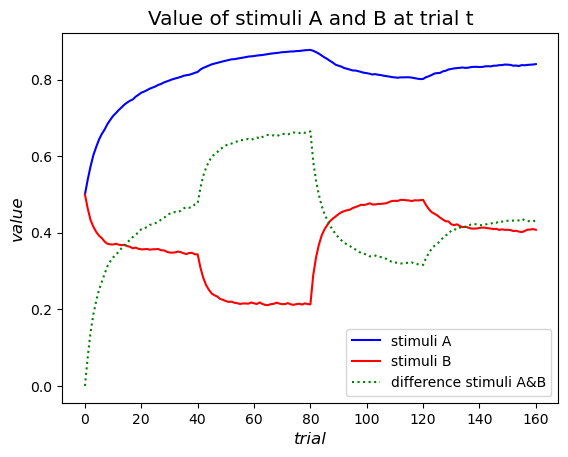

In [684]:
# Simulation: a = 0.4, b = 7, V0 = 0.5
# Average out the outcome for 10000 trials
np.random.seed(1)
n = 10000
value_a = np.zeros([n,161])
value_b = np.zeros([n,161])
for i in range(n):
    value_a[i] = outcome(0.4,7,prob_list,0.5)[2]
    value_b[i] = outcome(0.4,7,prob_list,0.5)[3]
value_a = np.mean(value_a,axis=0)
value_b = np.mean(value_b,axis=0)
plt.title('Value of stimuli A and B at trial t', fontsize = 'x-large')
plt.plot(value_a, color = 'b', label = "stimuli A")
plt.plot(value_b, color = 'r', label = "stimuli B")
plt.plot(np.array(value_a)-np.array(value_b), color = 'g', linestyle = 'dotted', label = "difference stimuli A&B")
plt.xlabel('trial', fontsize = 'large', fontstyle = 'italic')
plt.ylabel('value', fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='lower right')

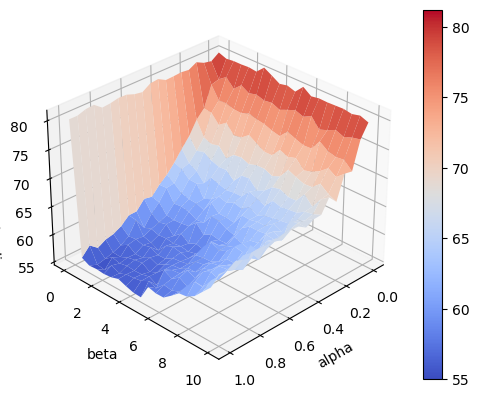

In [685]:
# Plot the average number of aversive stimuli received as a function of the parameter settings
# alpha determines the rate of learning, with higher values leading to faster learning. 
# beta determines the sensitivity to reward prediction errors, with higher values leading 
# to greater sensitivity. Thus, a higher alpha value may lead to faster adaptation to changes 
# in the environment, while a higher beta value may lead to more cautious behavior and fewer 
# aversive outcomes. However, there may be trade-offs between these parameters, as increasing 
# one parameter may negatively affect performance if the other parameter is not also adjusted appropriately. 

np.random.seed(1)
num = 20
n = 100
sim_mat = np.zeros([num,num])
alpha = (np.linspace(0,1,num))
beta = (np.linspace(0,10,num))
for i in range(num):
    for j in range(num):
        sim = np.zeros(n)
        for k in range (n):
            sim[k] = outcome(alpha[i],beta[j],prob_list,0.5)[-1]
        sim_mat[i][j] = np.mean(sim)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
X, Y = np.meshgrid(alpha, beta)
plot = ax.plot_surface(X, Y, sim_mat, cmap='coolwarm', vmin=np.min(sim_mat), vmax=np.max(sim_mat))
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('avg aversive stimuli')
fig.colorbar(plot)

plt.show()

### Likelihood function

In [686]:
# a function that takes as input the data (choices and outcomes) for an 
# individual and a vector of parameters (learning rate and inverse temperature) 
# and returns the negative log likelihood (NLL)

def nll(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

## test should be around 61 
test = nll([0.4,7],inst_choices[8],inst_outcomes[8],0.5); print(test)
nll4 = nll([0.4,7],inst_choices[3],inst_outcomes[3],0.5); print(nll4)
nll5 = nll([0.4,7],inst_choices[4],inst_outcomes[4],0.5); print(nll5)


60.877333438783324
101.6050206224349
52.68861467295329


### Model fitting

In [687]:
# Find the parameters that minimize the NLL for each individual, passing the NLL 
# function and a set of starting parameters (alpha = 0.4 and beta = 7) to a 
# optimization function performing unconstrained minimization.
# Use the the Nelder-Mead algorithm from scipy.optimize

fitted_param = []
for i in range(len(stai_scores)):
    fitted_param.append(sp.optimize.minimize(nll,x0=(0.4,7), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)

In [688]:
# Calculate the mean and variance of the fitted parameter values for learning rate and inverse temperature
# Also, obtain the Pearson’s correlation coefficient between estimated parameters
# Then, taking the first 25 participants as the high anxious group, calculate the Pearson’s correlation 
# coefficient between estimated parameters separately for participants within each group.

fitted_alpha, fitted_beta = np.array(fitted_param).T

mean_alpha = np.mean(fitted_alpha); print(mean_alpha)
var_alpha = np.var(fitted_alpha); print(var_alpha)
mean_beta = np.mean(fitted_beta); print(mean_beta)
var_beta = np.var(fitted_beta); print(var_beta)

mean_alpha_anxious = np.mean(fitted_alpha[:25]); print(mean_alpha_anxious)
mean_alpha_control = np.mean(fitted_alpha[25:]); print(mean_alpha_control)
mean_beta_anxious = np.mean(fitted_beta[:25]); print(mean_beta_anxious)
mean_beta_control = np.mean(fitted_beta[25:]); print(mean_beta_control)

print(sp.stats.pearsonr(fitted_alpha, fitted_beta))
print(sp.stats.pearsonr(fitted_alpha[:25], fitted_beta[:25]))
print(sp.stats.pearsonr(fitted_alpha[25:], fitted_beta[25:]))

0.4758865798481678
0.028823177110009483
5.165364859938008
2.7646122988261386
0.5874739980369317
0.36429916165940396
4.655724358126161
5.6750053617498555
PearsonRResult(statistic=-0.2369656492300812, pvalue=0.09753716137988659)
PearsonRResult(statistic=-0.46745261030155233, pvalue=0.01846598704926908)
PearsonRResult(statistic=0.40900638521961774, pvalue=0.04234454107340218)


Text(0.5, 1.0, 'beta')

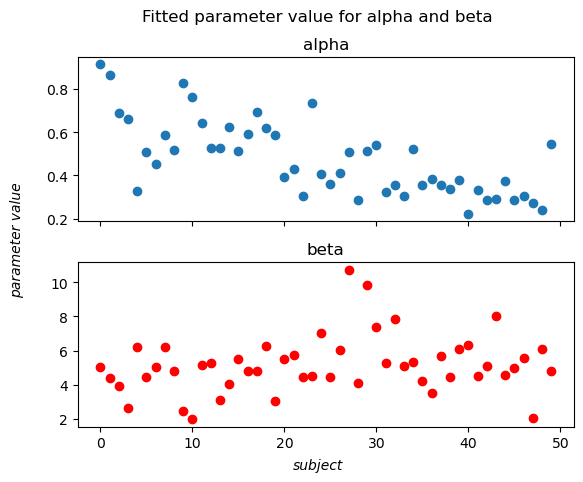

In [689]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha)
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),fitted_beta, color = 'red')
ax[1].set_title('beta')

### Group comparison

In [690]:
# If the data was real and we obtained a significant result, we might conclude that 
# there is a meaningful difference between the parameter values for the two groups. 
# This could support our hypothesis that high anxiety is associated with differences 
# in decision-making processes.

dof = len(fitted_alpha[:25]) + len(fitted_alpha[25:]) - 2; print(dof)
print(sp.stats.ttest_ind(fitted_alpha[:25], fitted_alpha[25:], equal_var=False))
print(sp.stats.ttest_ind(fitted_beta[:25], fitted_beta[25:], equal_var=False))

48
Ttest_indResult(statistic=6.042165319443778, pvalue=4.539257722057438e-07)
Ttest_indResult(statistic=-2.2309569492149133, pvalue=0.031110531474266866)


### Parameter recovery

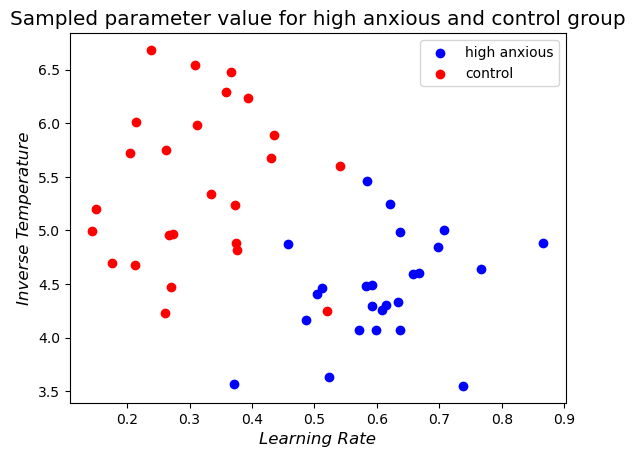

In [691]:
# Sample 50 sets of parameter values of learning rate and inverse temperature from a multivariate normal distributions

def gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control):
    var_learning_rate = 0.01
    var_inv_temp = 0.5
    cov = 0

    # anxious group
    mean = [mean_alpha_anxious, mean_beta_anxious]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values = np.random.multivariate_normal(mean, covariance, 25)

    min_learning_rate = 0
    max_learning_rate = 1
    min_inv_temp = 0
    max_inv_temp = 10

    while True:
        invalid_indices = np.where((param_values[:, 0] < min_learning_rate) | 
                                (param_values[:, 0] > max_learning_rate) | 
                                (param_values[:, 1] < min_inv_temp) |
                                (param_values[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))


    # control group
    mean = [mean_alpha_control, mean_beta_control]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values_c = np.random.multivariate_normal(mean, covariance, 25)

    min_learning_rate = 0
    max_learning_rate = 1
    min_inv_temp = 0
    max_inv_temp = 10

    while True:
        invalid_indices = np.where((param_values_c[:, 0] < min_learning_rate) | 
                                (param_values_c[:, 0] > max_learning_rate) | 
                                (param_values_c[:, 1] < min_inv_temp) |
                                (param_values_c[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values_c[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))

    return np.concatenate((param_values, param_values_c))

param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)

plt.title('Sampled parameter value for high anxious and control group', fontsize = 'x-large')
plt.scatter(param_values[:25, 0], param_values[:25, 1],color = 'b', label = "high anxious")
plt.scatter(param_values[25:, 0], param_values[25:, 1],color = 'r', label = "control")
plt.xlabel('Learning Rate',fontsize = 'large', fontstyle = 'italic')
plt.ylabel('Inverse Temperature',fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='upper right')

In [692]:
# Use the sampled parameter values to simulate 50 sets of data. 
# Fit new parameter values to these simulated data sets.
# Calculate the Pearson’s correlation between the parameter values used to
# simulate the data and the parameter values that you obtained from fitting 
# the model to the simulated data.

def param_sim(param_values):
    sim_choice = []
    sim_outcome = []
    for i in range(50):
        sim_choice.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[1])
        sim_outcome.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[0])

    fitted_param_1 = []
    for i in range(len(stai_scores)):
        fitted_param_1.append(sp.optimize.minimize(nll,x0=(param_values[i][0],param_values[i][1]), args=(sim_choice[i],sim_outcome[i],0.5),method='Nelder-Mead').x)

    fitted_alpha_1, fitted_beta_1 = np.array(fitted_param_1).T
    print(sp.stats.pearsonr(fitted_alpha_1, fitted_beta_1))
    print(sp.stats.pearsonr(fitted_alpha_1[:25], fitted_beta_1[:25]))
    print(sp.stats.pearsonr(fitted_alpha_1[25:], fitted_beta_1[25:]))

PearsonRResult(statistic=-0.5176595920816222, pvalue=0.00011816052424766022)
PearsonRResult(statistic=-0.2441641461674449, pvalue=0.2395044328329391)
PearsonRResult(statistic=0.05575396361616305, pvalue=0.7912378512564295)
PearsonRResult(statistic=-0.3061870329198864, pvalue=0.030576346456767618)
PearsonRResult(statistic=0.32489068190383047, pvalue=0.11305219562249766)
PearsonRResult(statistic=-0.10756328277888064, pvalue=0.6088111737838938)
PearsonRResult(statistic=-0.5070917246292667, pvalue=0.0001711596029987141)
PearsonRResult(statistic=0.08997391672862923, pvalue=0.6688642672949732)
PearsonRResult(statistic=0.06577304904865938, pvalue=0.7547616660104276)
PearsonRResult(statistic=-0.4241085487088104, pvalue=0.002145219796311396)
PearsonRResult(statistic=0.06513909046526838, pvalue=0.7570555209015983)
PearsonRResult(statistic=0.18921749884508837, pvalue=0.3650030844013394)
PearsonRResult(statistic=-0.6142692867004315, pvalue=2.087361840742583e-06)
PearsonRResult(statistic=-0.0936480

Text(0.5, 1.0, 'beta')

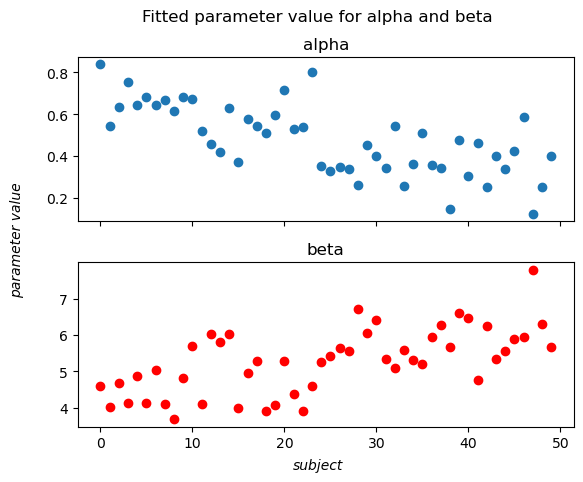

In [693]:
for i in range(5):
    param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)
    param_sim(param_values)

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),np.array(param_values).T[0])
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),np.array(param_values).T[1], color = 'red')
ax[1].set_title('beta')

### Alternative model

67.173
65.74883527384853
85.92844463028467
62.04020303395902


/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_10661/1356614314.py:46: RuntimeWarning: overflow encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))


Text(0.5, 1.0, 'beta')

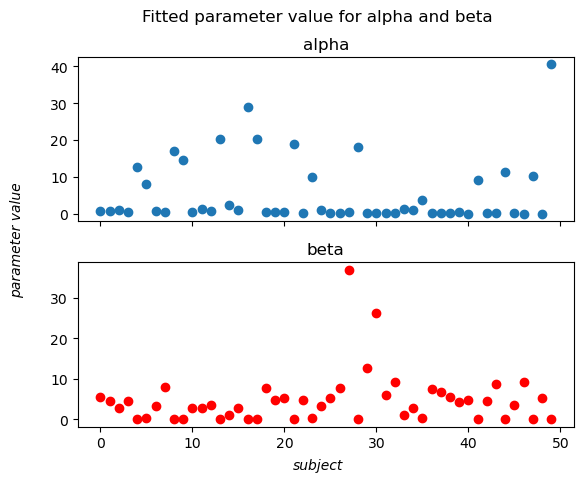

In [702]:
# introduce a parameter, A
# Action selection for this model is again performed by the same softmax equation

def outcome_alt(A,a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)

def nll_alt(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    A, a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

test_alt = []
for i in range(1000):
    test_alt.append(outcome_alt(0.5,0.4,7,prob_list,0.5)[-1])
print(np.mean(test_alt))

test_alt1 = nll_alt([0.5,0.4,7],inst_choices[8],inst_outcomes[8],0.5); print(test_alt1)
nll4_alt = nll_alt([0.5,0.4,7],inst_choices[3],inst_outcomes[3],0.5); print(nll4_alt)
nll5_alt = nll_alt([0.5,0.4,7],inst_choices[4],inst_outcomes[4],0.5); print(nll5_alt)

fitted_param_alt = []
for i in range(len(stai_scores)):
    fitted_param_alt.append(sp.optimize.minimize(nll_alt,x0=(0.5,0.4,7), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)
fitted_a_alt, fitted_alpha_alt, fitted_beta_alt = np.array(fitted_param_alt).T

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta')

In [703]:
def AIC(nll,p):
    return 2*nll+2*p

def BIC(nll,p):
    return 2*nll+p*np.ma.log(160)

p = 3
nll_list = []
nll_alt_list = []
AIC_list = []
AIC_alt_list = []
BIC_list = []
BIC_alt_list = []
for i in range(50):
    nll_list.append(nll([0.4,7],inst_choices[i],inst_outcomes[i],0.5))
    nll_alt_list.append(nll_alt([0.5,0.4,7],inst_choices[i],inst_outcomes[i],0.5))
    AIC_list.append(AIC(nll_list[i],p))
    AIC_alt_list.append(AIC(nll_alt_list[i],p))
    BIC_list.append(BIC(nll_list[i],p))
    BIC_alt_list.append(BIC(nll_alt_list[i],p))

print(nll_list)
print(nll_alt_list)
print(np.sum(AIC_list))
print(np.sum(AIC_alt_list))
print(np.sum(BIC_list))
print(np.sum(BIC_alt_list))

[71.89501709469803, 73.99902852070569, 63.48782166698683, 101.6050206224349, 52.68861467295329, 49.57025421866699, 51.67640689447347, 45.83387519851256, 60.877333438783324, 96.87827871571137, 121.82979052419863, 55.29336425971195, 45.302956732572476, 89.96392053484107, 69.0933773743769, 49.75817622629023, 61.54695515722878, 59.49679091453134, 40.11875819260712, 88.01597053519866, 61.01663621129176, 48.3936151673412, 74.3030016861751, 67.12210773918608, 38.78085225784171, 78.6687645503986, 45.88392040154698, 14.90590504976406, 68.62440500070787, 14.216069440154536, 22.19957601403611, 61.98829560327881, 24.47260689318613, 57.10556070235257, 39.12374571586506, 75.054059133254, 82.86536965051516, 63.258209037338545, 77.92305108365144, 35.92353527738445, 70.25209035730177, 62.85353933223457, 73.12094788753735, 59.81012524236908, 71.10489274283533, 69.4479720246508, 40.93620401075032, 145.89307779287049, 60.93348773619517, 46.915889434129014]
[52.203947410800026, 55.099495389326734, 58.26546

67.126
65.74883527384853
85.92844463028467
62.04020303395902


Text(0.5, 1.0, 'beta')

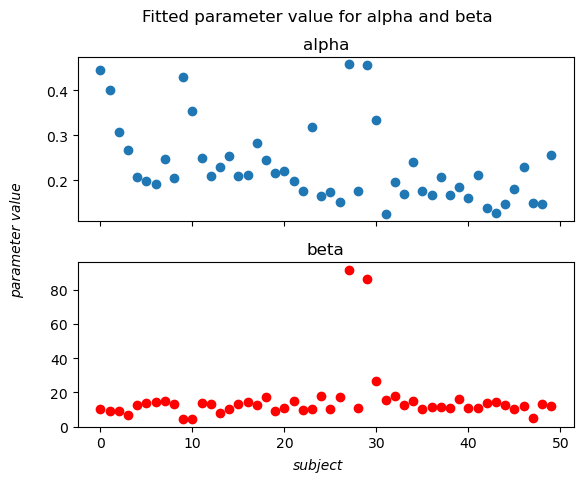

In [705]:
# version A not included in optimisation

def nll_alt(params, A, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

test_alt = []
for i in range(1000):
    test_alt.append(outcome_alt(0.5,0.4,7,prob_list,0.5)[-1])
print(np.mean(test_alt))

test_alt1 = nll_alt([0.4,7],0.5,inst_choices[8],inst_outcomes[8],0.5); print(test_alt1)
nll4_alt = nll_alt([0.4,7],0.5,inst_choices[3],inst_outcomes[3],0.5); print(nll4_alt)
nll5_alt = nll_alt([0.4,7],0.5,inst_choices[4],inst_outcomes[4],0.5); print(nll5_alt)

fitted_param_alt = []
for i in range(len(stai_scores)):
    fitted_param_alt.append(sp.optimize.minimize(nll_alt,x0=(0.4,7), args=(0.5,inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)

fitted_alpha_alt, fitted_beta_alt = np.array(fitted_param_alt).T

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta')

### Model comparison

In [706]:
# Compare the negative log likelihood values between the two models
# For each participant, compute AIC and BIC scores for each model

def AIC(nll,p):
    return 2*nll+2*p

def BIC(nll,p):
    return 2*nll+p*np.ma.log(160)

p = 3
nll_list = []
nll_alt_list = []
AIC_list = []
AIC_alt_list = []
BIC_list = []
BIC_alt_list = []
for i in range(50):
    nll_list.append(nll([0.4,7],inst_choices[i],inst_outcomes[i],0.5))
    nll_alt_list.append(nll_alt([0.4,7],0.5,inst_choices[i],inst_outcomes[i],0.5))
    AIC_list.append(AIC(nll_list[i],p))
    AIC_alt_list.append(AIC(nll_alt_list[i],p))
    BIC_list.append(BIC(nll_list[i],p))
    BIC_alt_list.append(BIC(nll_alt_list[i],p))

print(nll_list)
print(nll_alt_list)
print(np.sum(AIC_list))
print(np.sum(AIC_alt_list))
print(np.sum(BIC_list))
print(np.sum(BIC_alt_list))

[71.89501709469803, 73.99902852070569, 63.48782166698683, 101.6050206224349, 52.68861467295329, 49.57025421866699, 51.67640689447347, 45.83387519851256, 60.877333438783324, 96.87827871571137, 121.82979052419863, 55.29336425971195, 45.302956732572476, 89.96392053484107, 69.0933773743769, 49.75817622629023, 61.54695515722878, 59.49679091453134, 40.11875819260712, 88.01597053519866, 61.01663621129176, 48.3936151673412, 74.3030016861751, 67.12210773918608, 38.78085225784171, 78.6687645503986, 45.88392040154698, 14.90590504976406, 68.62440500070787, 14.216069440154536, 22.19957601403611, 61.98829560327881, 24.47260689318613, 57.10556070235257, 39.12374571586506, 75.054059133254, 82.86536965051516, 63.258209037338545, 77.92305108365144, 35.92353527738445, 70.25209035730177, 62.85353933223457, 73.12094788753735, 59.81012524236908, 71.10489274283533, 69.4479720246508, 40.93620401075032, 145.89307779287049, 60.93348773619517, 46.915889434129014]
[52.203947410800026, 55.099495389326734, 58.26546